## Parametrization of the NFW profile by MGE.

This generates a NFW MGE parametrization, that can be used for lens and dynamical modelling. We parametrize the 1-dimensional version of the profile, and after we set the projected axial ratio.

To do that, we use the Spherical Version of the NFW, and the ellipticity is introduced only by the projected axial ratio. This assumes that the position angle is zero, i.e, the semi-mjor axis is parallel to x-axis.

## Sperical NFW

The classical spherical NFW profile is:
<center> $\rho(r) = \frac{\rho_s}{(r/r_s)  (1 + r/r_s)^2 }$.
    
    
But in terms of the critical surface density,
<center> $\Sigma_{crit} = \frac{c^2}{4\pi G} \frac{D_s}{D_l D_{ls}}$    
    
we have:
<center> $\rho(r) = \frac{\kappa_s \Sigma_{crit}}{r(1 + r/r_s)^2 }$,

where: $\kappa_s = \frac{\rho_s r_s}{\Sigma_{crit}}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mge_fit_1d import mge_fit_1d 
#To change the labels, we need to edit directly the script mge_fit_1d.py in THIS folder.
from jampy.mge_half_light_isophote import mge_half_light_isophote   #Compute half light radius
from jampy.mge_half_light_isophote import mge_half_light_radius     #Compute half light radius (other way)
from jampy import mge_radial_mass                                   #Compute mass inside some radius

from astropy.cosmology import Planck15 as cosmo
from astropy import units as u
from astropy import table

from astropy.cosmology import Planck15
from astropy.constants import G, M_sun, c
import astropy.units as u
from scipy.integrate import quad

In [2]:
def Sph_NFW(rho_s, r_s, r):
    """
        Classical Spherical NFW profile.
    """
    return rho_s / ( (r/r_s) * (1 + r/r_s)**2 )



def Sph_NFW_lens(kappa_s, r_s, den_crit, r):
    """
        Classical Spherical NFW profile, usually used in lensing models. Here, the profile is writed in terms of
        kappa_s, which is a constant scale factor defined above in this notebook.
    """
    return (kappa_s * den_crit) / (r * (1 + r/r_s)**2 )

def Sph_NFW_lens_integral(r,
                          kappa_s, r_s, den_crit):
    """
        Integrant of classical Spherical NFW profile. Integrating this function you get the mass inside
        some radius.
    """
    return 4* np.pi * r**2 * (kappa_s * den_crit) / (r * (1 + r/r_s)**2 )

In [3]:
metre2Mpc = (1*u.m).to(u.Mpc)/u.m             #Constant factor to convert metre to Mpc.
kg2Msun   = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun


G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

In [4]:
#Redshift
z_l = 0.299 
z_s = 4.100

#Angular diametre distances
D_l  = Planck15.angular_diameter_distance(z_l)
D_s  = Planck15.angular_diameter_distance(z_s)
D_ls = Planck15.angular_diameter_distance_z1z2(z_l, z_s)

#Lens Critical Density
critical_density = ((c_Mpc**2/(4*np.pi*G_Mpc)) * (D_s/(D_ls * D_l))).to(u.solMass/u.pc**2)

In [5]:
kappa_s = 1.000                                                                #Lens scale factor [Ad]
r_s     = ( (10 * 1.15 * u.arcsec) * D_l ).to(u.pc, u.dimensionless_angles())  #Scale radius      [pc]
rho_s   = ( kappa_s * critical_density ) / r_s                                 #Scale density     [M_sun/pc^3]

r = np.logspace(-2.5, 10, 300) #Radii [pc]
print("Min: %.3e arcs, Max: %.3e arcs" %( r.min()/(D_l.value*np.pi/0.648), r.max()/(D_l.value*np.pi/0.648) ))

Min: 6.900e-07 arcs, Max: 2.182e+06 arcs


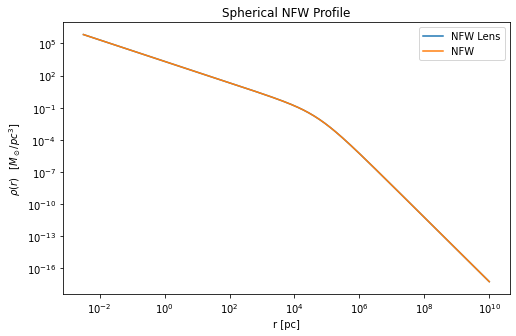

In [6]:
NFW_profile_lens = Sph_NFW_lens(kappa_s, r_s.value, critical_density.value, r)
NFW_profile      = Sph_NFW(rho_s.value, r_s.value, r)

plt.figure(figsize=(8,5))
plt.loglog(r, NFW_profile_lens, label="NFW Lens")
plt.loglog(r, NFW_profile, label="NFW")

plt.title("Spherical NFW Profile")
plt.xlabel("r [pc]")
plt.ylabel("$\\rho(r)$ $\\,$ [$M_\\odot$/$pc^3$]")
plt.legend()

## MGE parametrization

Iteration: 1  chi2: 0.1369 Nonzero: 40/40
Iteration: 11  chi2: 0.02571 Nonzero: 40/40
Iteration: 21  chi2: 0.01903 Nonzero: 40/40
Iteration: 31  chi2: 0.01544 Nonzero: 40/40
Iteration: 41  chi2: 0.01351 Nonzero: 40/40
Iteration: 51  chi2: 0.01249 Nonzero: 40/40
Iteration: 61  chi2: 0.01201 Nonzero: 40/40
Iteration: 71  chi2: 0.01197 Nonzero: 40/40
Iteration: 73  chi2: 0.01197 Nonzero: 40/40
############################################
 Computation time: 5.08 seconds
 Total Iterations:  73
Nonzero Gaussians:  40
 Unused Gaussians:  0
 Chi2: 0.01197 
 STDEV: 0.006316
 MEANABSDEV: 0.005648
############################################
 Total_Counts      Sigma
############################################
      3636.55   0.00237325
      3571.63   0.00556356
       3551.8    0.0129456
      3536.36    0.0299985
      3524.16    0.0692877
      3514.98     0.159629
       3508.7     0.367091
       3505.2     0.843204
      3504.36      1.93584
         3506      4.44475
      3509.88      10

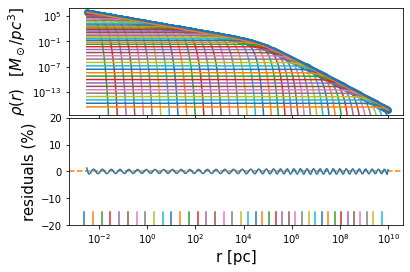

In [7]:
m = mge_fit_1d(r, NFW_profile_lens, ngauss=40, outer_slope=2.5, plot=True)

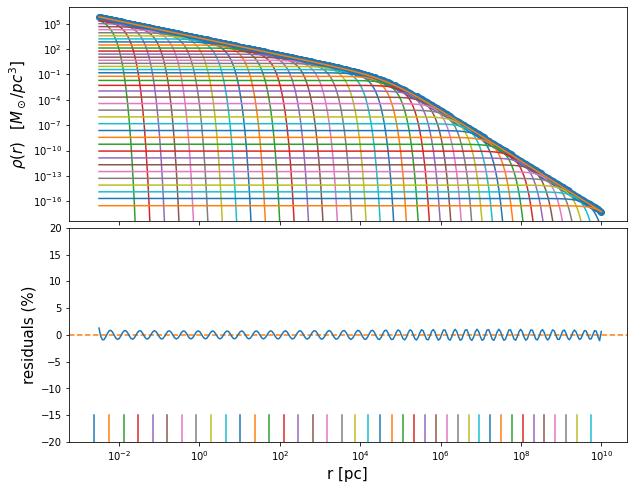

In [8]:
plt.figure(figsize=(10,8))
m.plot()

In [12]:
#Converting quantities
surf  =  m.sol[0]                           # Surface density in Msun/pc**2
sigma = m.sol[1]/(D_l.value*np.pi/0.648)    # Gaussian dispersion in arcsec
qObs  = np.full_like(surf, 0.85)             # Assume spherical model

In [13]:
np.savetxt('SphNFW_2e3arcsec.txt', np.column_stack([surf, sigma, qObs]),
                            fmt=b'%5.5e\t\t\t %5.5e\t\t %5.5e', 
                            header='Surface Potential(M_sun/pc²) Sigma Potential(arcsec)    qObs')